In [315]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysankey import sankey
from tqdm import tqdm, trange

In [316]:
LOG_PERIOD = 10

class Economy:
    def __init__(self, productivity0, labor0, capital0, lamb_L, lamb_K, CL, CK, DL, DK, rho, innovation=False, capacity_factor=10):
        self.productivity = productivity0
        self.labor = labor0
        self.capital = capital0
        self.lamb_L = lamb_L
        self.lamb_K = lamb_K
        self.lamb_A = 0
        self.CL = CL
        self.CK = CK
        self.DL = DL
        self.DK = DK
        self.rho = np.ones_like(labor0) * rho
        self.innovation = innovation
        self.capacity_factor = capacity_factor

        self.steps = 0
        self.dt = 0.001
        
        self.labor_hist = [labor0]
        self.capital_hist = [capital0]
        self.production_hist = [self.production]
        
    def update(self):
        labor = np.copy(self.labor)
        capital = np.copy(self.capital)
        productivity = np.copy(self.productivity)

        if self.capacity_factor:
            capacity = self.production * self.capacity_factor
            # labor += self.dt * self.lamb_L * self.labor * (1 - self.labor / capacity) - self.dt * self.labor * np.dot(self.CL, self.capital)
            labor += self.dt * self.lamb_L * self.labor * (1 - self.labor / capacity) - self.dt * self.labor * np.dot(self.CL, (self.capital / (1 + 0.1 * self.capital)))
            # labor += self.dt * self.lamb_L * self.labor * (1 - self.labor / np.sum(self.labor)) - self.dt * self.labor * np.dot(self.CL, (self.capital / (1 + 0.1 * self.capital)))
            # capital += self.dt * self.capital * np.dot(self.CK, self.labor) - self.dt * self.lamb_K * self.capital
            # capital += self.dt * np.dot(self.CK, self.labor) - self.dt * self.lamb_K * self.capital
            capital += self.dt * self.capital * np.dot(self.CK, (self.labor / (1 + 0.1 * self.labor))) - self.dt * self.lamb_K * self.capital
        else:
            labor += self.dt * self.lamb_L * self.labor - self.dt * self.labor * np.dot(self.CL, self.capital)
            capital += self.dt * self.capital * np.dot(self.CK, self.labor) - self.dt * self.lamb_K * self.capital
        
        labor -= self.dt * self.labor * np.dot(self.DL, self.labor)
        # labor -= self.dt * self.labor * np.dot(self.DL, np.maximum(self.labor - 1, 0))
        # labor -= self.dt * np.maximum(self.labor - 1, 0) * np.dot(self.DL, self.labor)
        capital -= self.dt * self.capital * np.dot(self.DK, self.capital)
        
        if self.innovation:
            productivity += self.dt * self.productivity * (self.lamb_A + 0.1 * np.dot(self.DL, self.labor) + 0.1 * np.dot(self.DK, self.capital))
        else:
            productivity += self.dt * self.productivity * self.lamb_A
        
        self.labor = labor
        self.capital = capital
        self.productivity = productivity
        self.steps += 1
        
        if self.steps % LOG_PERIOD == 0:
            self.labor_hist.append(self.labor)
            self.capital_hist.append(self.capital)
            self.production_hist.append(self.production)
    
    @property
    def production(self):
        return self.productivity * self.labor ** self.rho * self.capital ** (1 - self.rho)


def plot_classes(hist, label):
    data = np.concatenate(hist)
    data = pd.DataFrame(data, columns=[label])
    N = len(hist[0])
    T = len(hist)
    sector = [i for i in range(N)] * T
    data['sector'] = sector
    steps = []
    for t in range(T):
        steps += [t * LOG_PERIOD] * N
    data['steps'] = steps
    
    sns.set_style('whitegrid')
    ax = sns.lineplot(x='steps', y=label, hue='sector', data=data)
    
    for line in ax.lines:
        line.set_alpha(0.5)
    
    
def plot_aggregate(prod_hist, labor_hist, capital_hist):
    agg_prod_hist = [np.sum(row) for row in prod_hist]
    agg_labor_hist = [np.sum(row) for row in labor_hist]
    agg_capital_hist = [np.sum(row) for row in capital_hist]
    data = np.concatenate([agg_prod_hist, agg_labor_hist, agg_capital_hist])
    data = pd.DataFrame(data, columns=['quantity'])
    T = len(agg_prod_hist)
    variable = ['production'] * T + ['labor'] * T + ['capital'] * T
    data['variable'] = variable
    steps = [t * LOG_PERIOD for t in range(T)] + [t * LOG_PERIOD for t in range(T)] + [t * LOG_PERIOD for t in range(T)]
    data['steps'] = steps
    
    sns.set_style('whitegrid')
    sns.lineplot(x='steps', y='quantity', hue='variable', data=data)

In [317]:
econ_list = []
econ_names = ['1-to-1', 'm-to-n', 'crowding', 'cannibalistic', 'crowding innovation', 'cannibalistic innovation']
N = 100
T = 50000
productivity0 = np.linspace(1, 5, N)
labor0 = np.ones(N) * 1
capital0 = np.ones(N) * 1
lamb_L = 1
lamb_K = 1
rho = 0.5

# 1-to-1 capital labor interaction
CL = np.diag(np.ones(N))
CK = CL
DL = np.zeros((N, N))
DK = np.zeros((N, N))
econ = Economy(productivity0, labor0, capital0, lamb_L, lamb_K, CL, CK, DL, DK, rho)

for i in trange(T):
    econ.update()

econ_list.append(econ)

# m-to-n capital-labor interaction
CL = np.random.uniform(size=(N, N))
CL = np.where(CL > 0.8, 1., 0.)
CL /= N * 0.2 * lamb_L
CK = CL.T * lamb_K
DL = np.zeros((N, N))
DK = np.zeros((N, N))
econ = Economy(productivity0, labor0, capital0, lamb_L, lamb_K, CL, CK, DL, DK, rho)

for i in trange(T):
    econ.update()

econ_list.append(econ)

# crowding competition
CL = np.random.uniform(size=(N, N))
CL = np.where(CL > 0.8, 1., 0.)
CL /= N * 0.2 * lamb_L
CK = CL.T * lamb_K
# DL = np.random.uniform(size=(N, N))
# DL = np.where(DL > 0.9, 1., 0.)
# DL = np.triu(DL, 1) + np.triu(DL, 1).T + np.identity(N)
# DL = DL / N
# DK = np.random.uniform(size=(N, N))
# DK = np.where(DK > 0.9, 1., 0.)
# DK = np.triu(DK, 1) + np.triu(DK, 1).T + np.identity(N)
# DK = DK / N
# DL = np.random.normal(size=(N, N))
# DL = np.triu(DL, 1) - np.triu(DL, 1).T
# DL = DL / N
# DK = np.random.normal(size=(N, N))
# DK = np.triu(DK, 1) - np.triu(DK, 1).T
# DK = DK / N
DL = np.identity(N)
DL = DL / N * lamb_L
DK = np.identity(N)
DK = DK / N * lamb_K
econ = Economy(productivity0, labor0, capital0, lamb_L, lamb_K, CL, CK, DL, DK, rho)

for i in trange(T):
    econ.update()

econ_list.append(econ)

# cannibalistic competition
CL = np.random.uniform(size=(N, N))
CL = np.where(CL > 0.8, 1., 0.)
CL /= N * 0.2 * lamb_L
CK = CL.T * lamb_K
DL = np.random.normal(size=(N, N))
DL = np.triu(DL, 1) - np.triu(DL, 1).T + np.identity(N)
DL = DL / N * lamb_L
DK = np.random.normal(size=(N, N))
DK = np.triu(DK, 1) - np.triu(DK, 1).T + np.identity(N)
DK = DK / N * lamb_K
# DL = np.random.normal(size=(N, N))
# DL = DL - np.identity(N) * np.diag(DL)
# DL = DL / N
# DK = np.random.normal(size=(N, N))
# DK = DK - np.identity(N) * np.diag(DL)
# DK = DK / N
econ = Economy(productivity0, labor0, capital0, lamb_L, lamb_K, CL, CK, DL, DK, rho)

for i in trange(T):
    econ.update()

econ_list.append(econ)

# crowding competition with innovation
CL = np.random.uniform(size=(N, N))
CL = np.where(CL > 0.8, 1., 0.)
CL /= N * 0.2 * lamb_L
CK = CL.T * lamb_K
# DL = np.where(DL > 0.9, 1., 0.)
# DL = np.triu(DL, 1) + np.triu(DL, 1).T + np.identity(N)
# DL = DL / N
# DK = np.random.uniform(size=(N, N))
# DK = np.where(DK > 0.9, 1., 0.)
# DK = np.triu(DK, 1) + np.triu(DK, 1).T + np.identity(N)
# DK = DK / N
DL = np.identity(N)
DL = DL / N * lamb_L
DK = np.identity(N)
DK = DK / N * lamb_K
econ = Economy(productivity0, labor0, capital0, lamb_L, lamb_K, CL, CK, DL, DK, rho, innovation=True)

for i in trange(T):
    econ.update()

econ_list.append(econ)

# cannibalistic competition with innovation
CL = np.random.uniform(size=(N, N))
CL = np.where(CL > 0.8, 1., 0.)
CL /= N * 0.2 * lamb_L
CK = CL.T * lamb_K
DL = np.random.normal(size=(N, N))
DL = np.triu(DL, 1) - np.triu(DL, 1).T + np.identity(N)
# DL = np.where(np.abs(DL) > 1., DL, 0)
DL = DL / N * lamb_L
DK = np.random.normal(size=(N, N))
DK = np.triu(DK, 1) - np.triu(DK, 1).T + np.identity(N)
DK = DK / N * lamb_K
econ = Economy(productivity0, labor0, capital0, lamb_L, lamb_K, CL, CK, DL, DK, rho, innovation=True)

for i in trange(T):
    econ.update()

econ_list.append(econ)

100%|██████████| 50000/50000 [00:05<00:00, 9584.70it/s] 


1-to-1


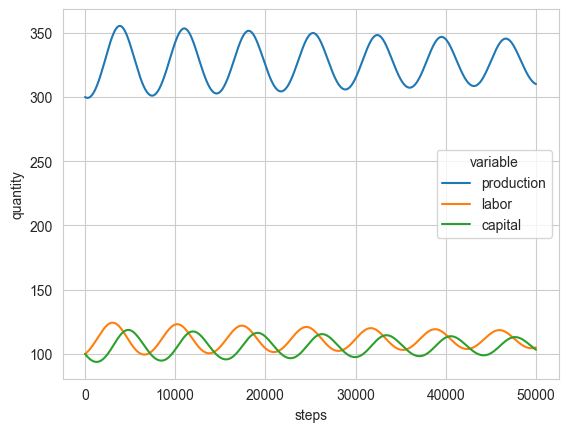

m-to-n


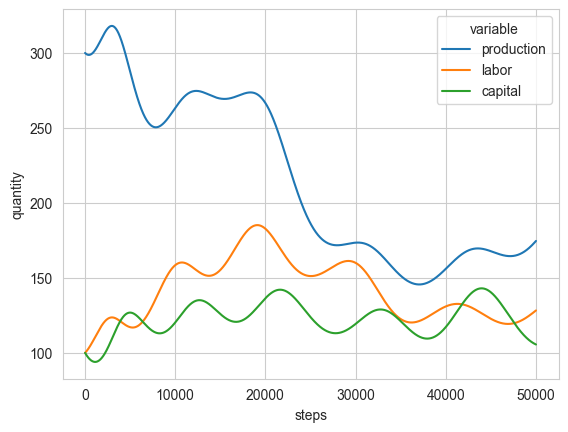

crowding


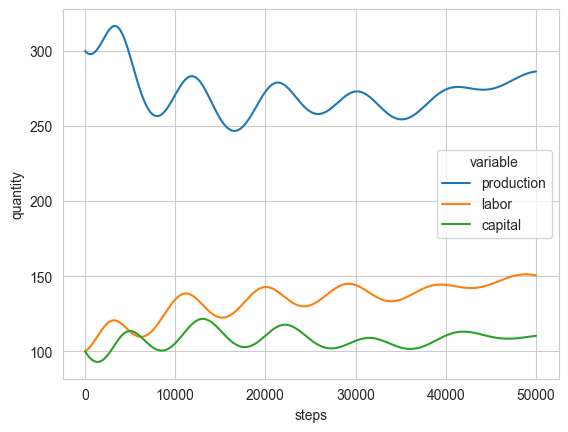

cannibalistic


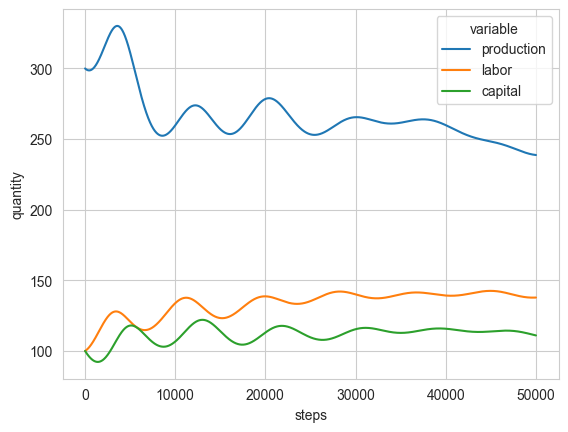

crowding innovation


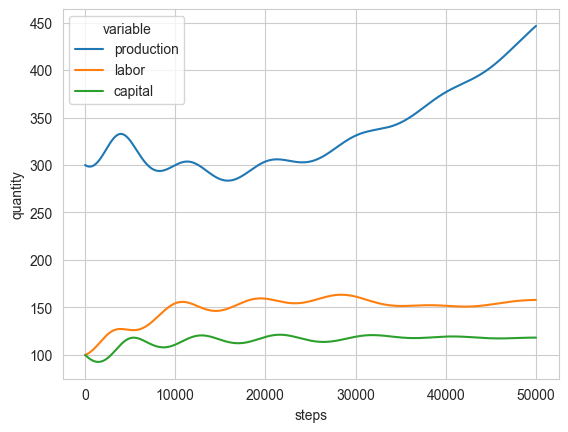

cannibalistic innovation


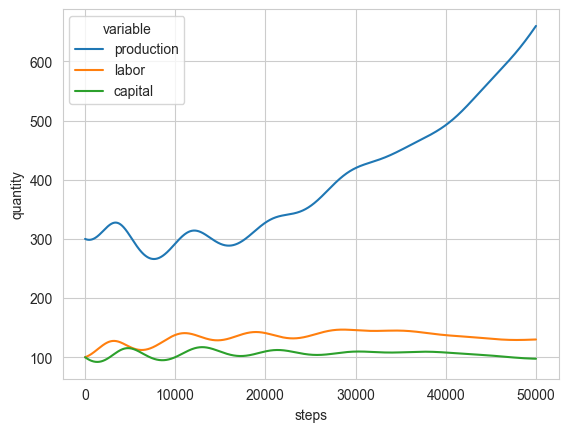

In [318]:
for i in range(len(econ_list)):
    plot_aggregate(econ_list[i].production_hist, econ_list[i].labor_hist, econ_list[i].capital_hist)
    print(econ_names[i])
    plt.show()

1-to-1


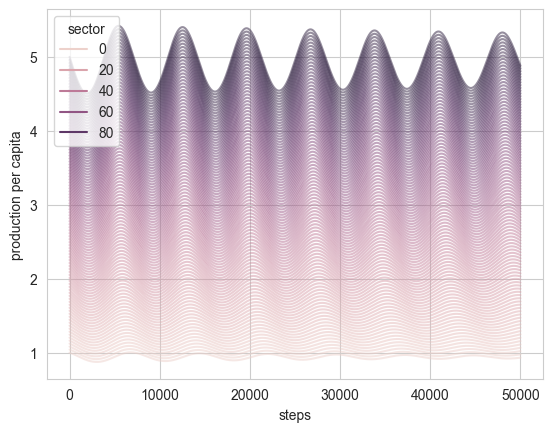

m-to-n


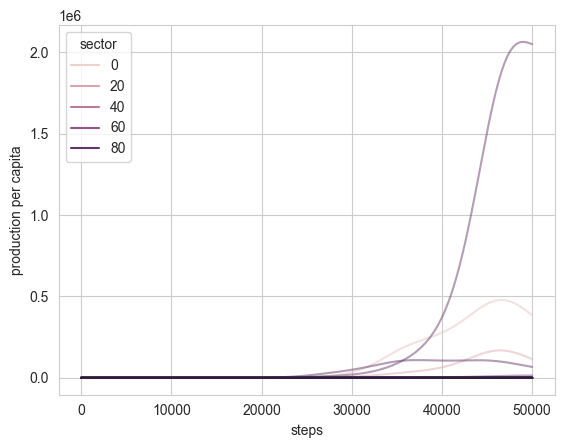

crowding


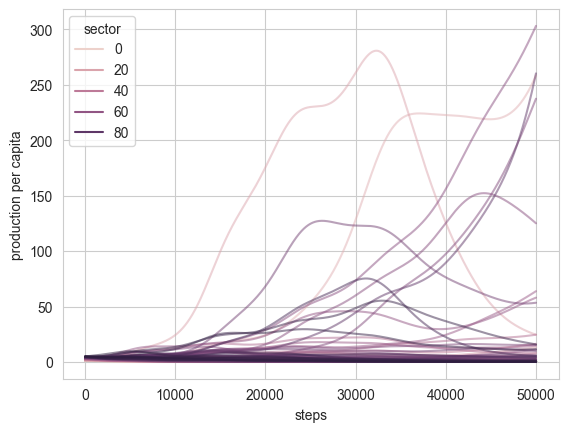

cannibalistic


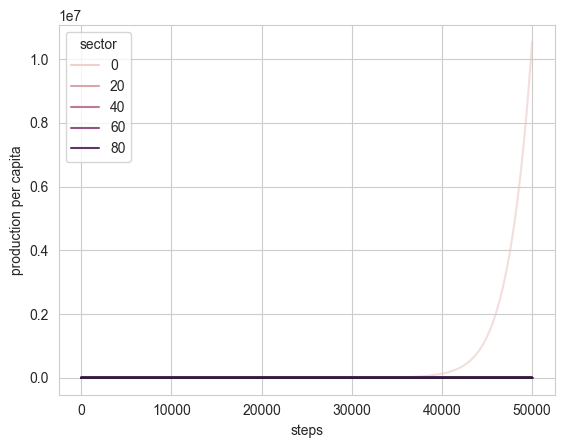

crowding innovation


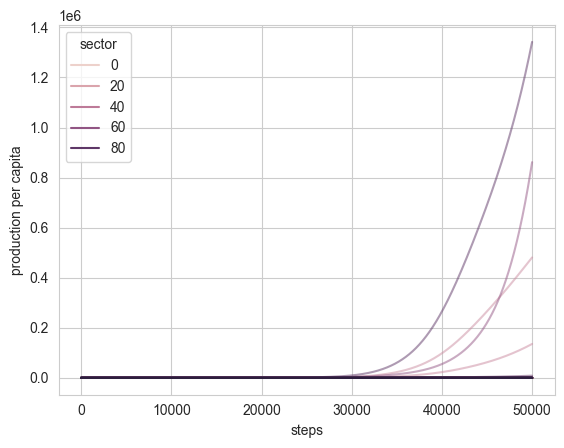

cannibalistic innovation


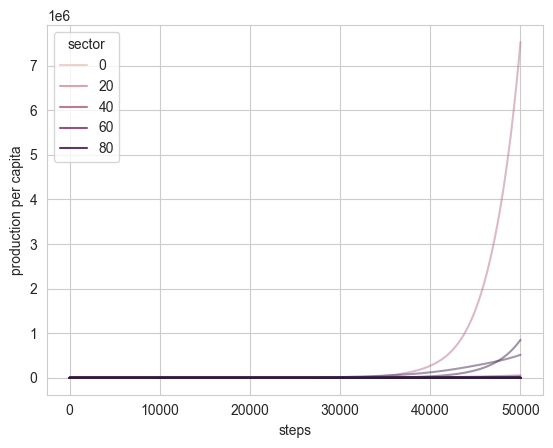

In [319]:
for i in range(len(econ_list)):
    plot_classes([econ_list[i].production_hist[t] / econ_list[i].labor_hist[t] for t in range(len(econ.labor_hist))], 'production per capita')
    print(econ_names[i])
    plt.show()

1-to-1


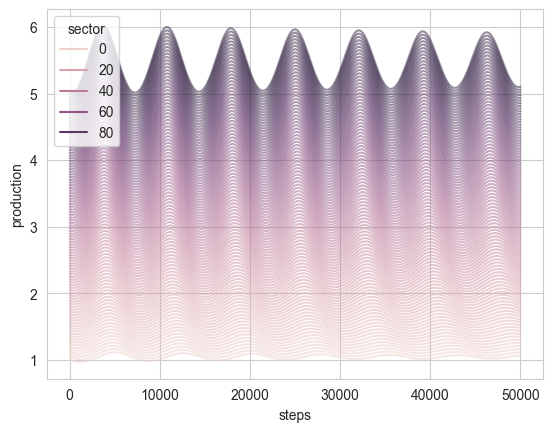

m-to-n


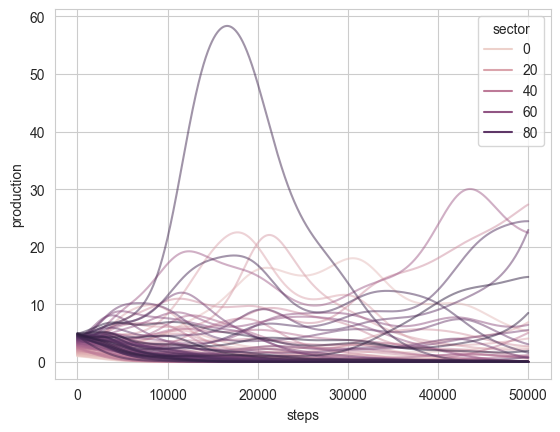

crowding


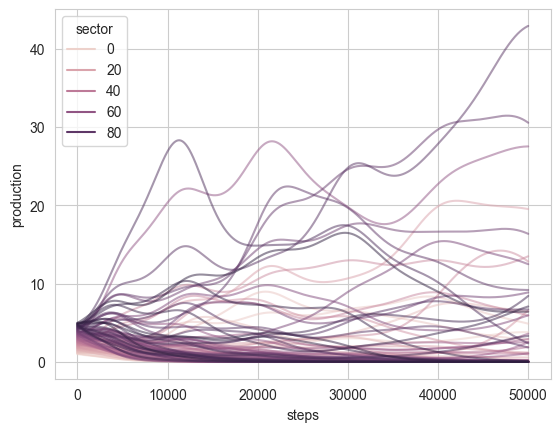

cannibalistic


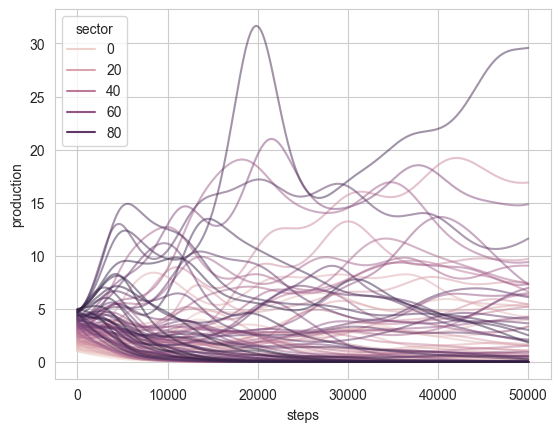

crowding innovation


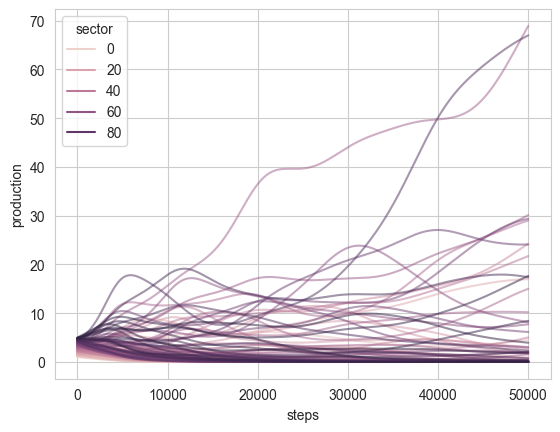

cannibalistic innovation


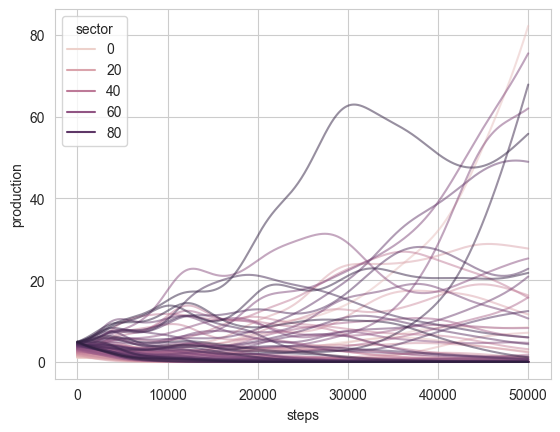

In [320]:
for i in range(len(econ_list)):
    plot_classes(econ_list[i].production_hist, 'production')
    print(econ_names[i])
    plt.show()

1-to-1


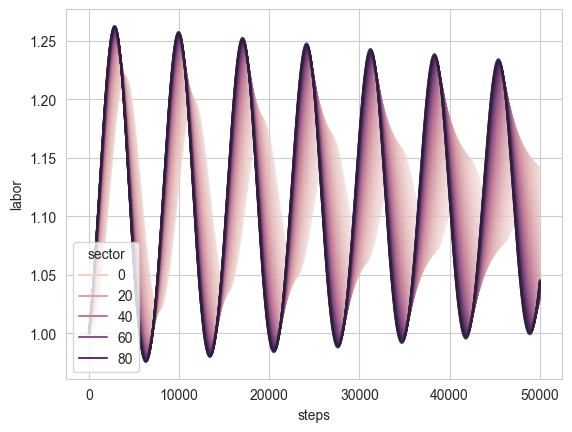

m-to-n


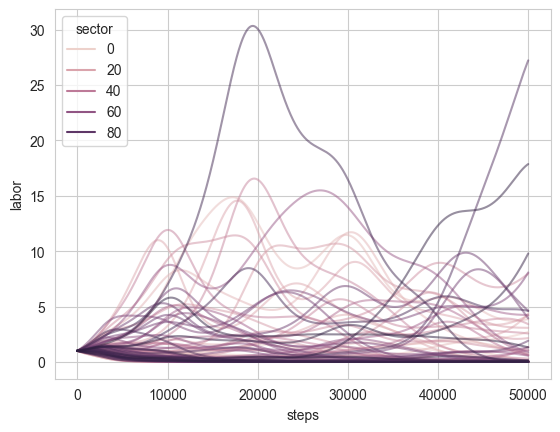

crowding


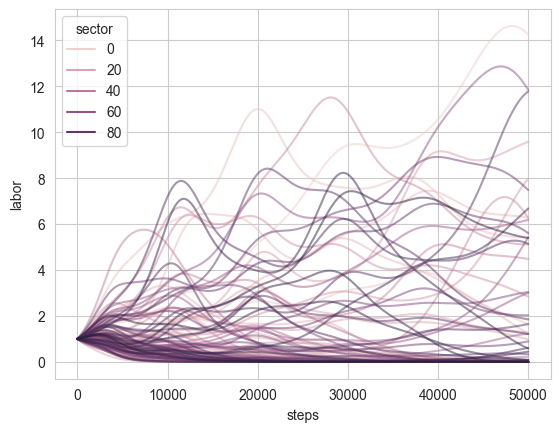

cannibalistic


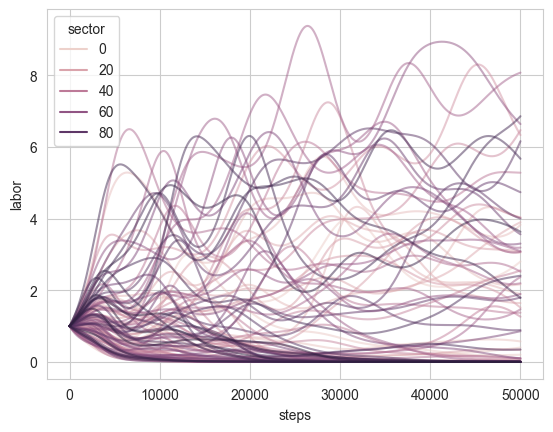

crowding innovation


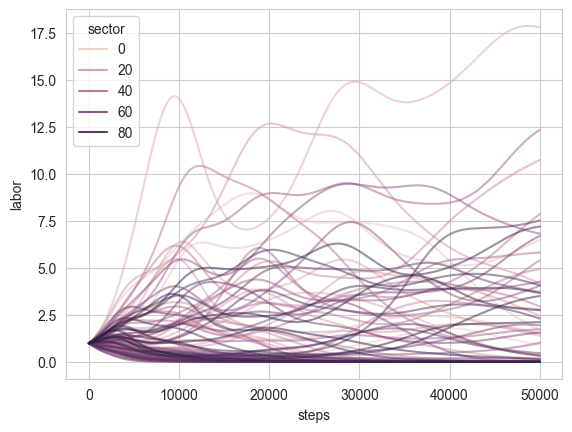

cannibalistic innovation


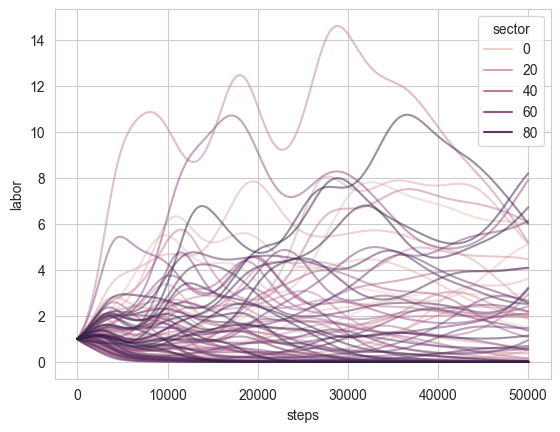

In [321]:
for i in range(len(econ_list)):
    plot_classes(econ_list[i].labor_hist, 'labor')
    print(econ_names[i])
    plt.show()

1-to-1


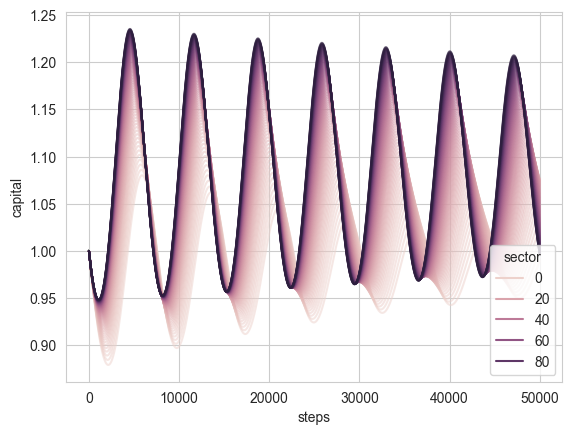

m-to-n


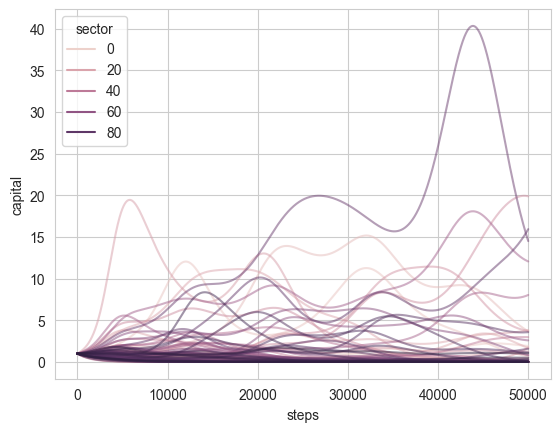

crowding


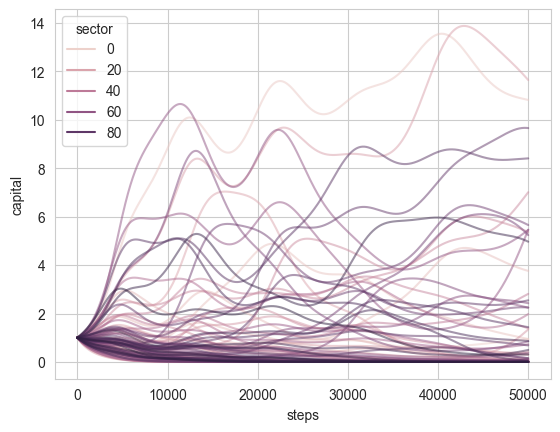

cannibalistic


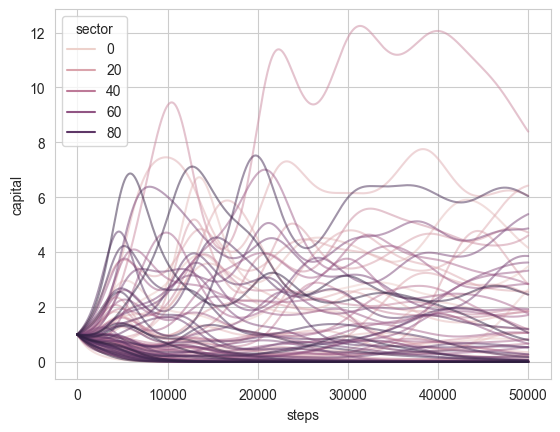

crowding innovation


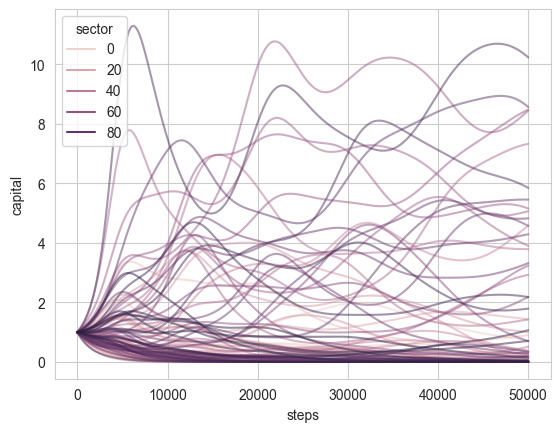

cannibalistic innovation


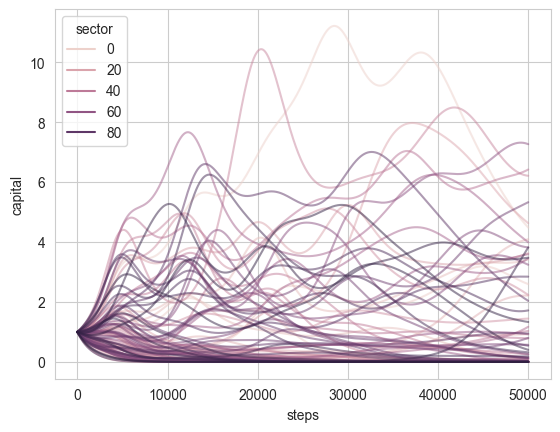

In [322]:
for i in range(len(econ_list)):
    plot_classes(econ_list[i].capital_hist, 'capital')
    print(econ_names[i])
    plt.show()

0.485114582191713
m-to-n


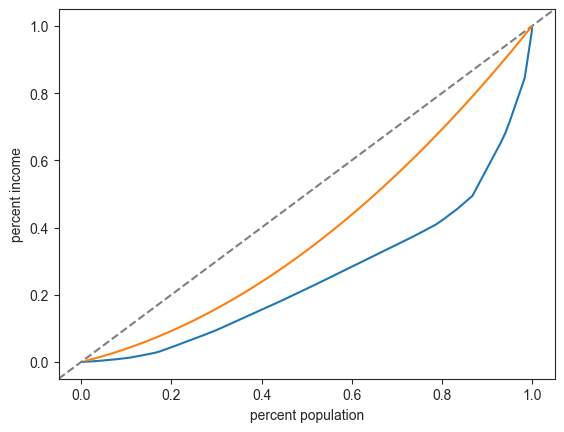

0.4545366153437761
crowding


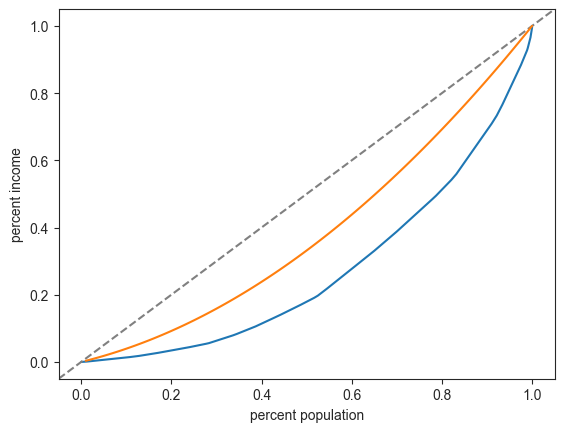

0.3943380652282624
cannibalistic


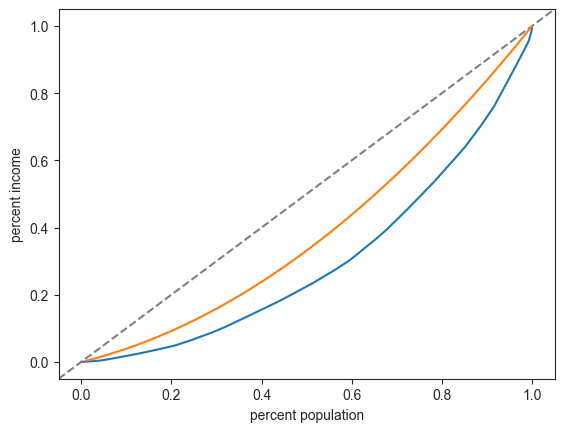

0.46742831730864853
crowding innovation


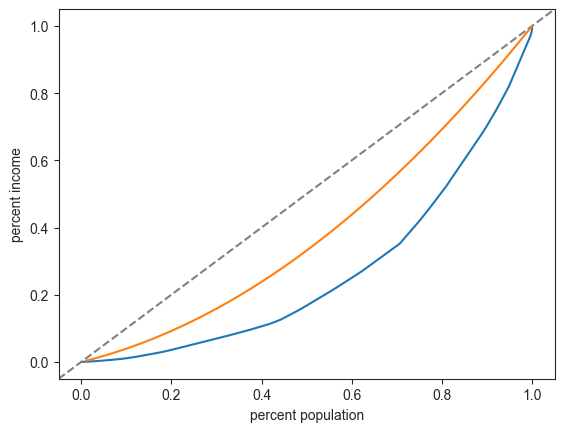

0.6097006880260782
cannibalistic innovation


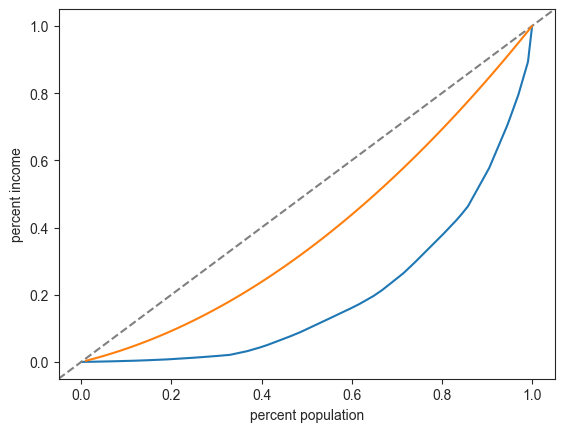

In [323]:
def plot_lorentz(xy1, xy2=None):
    x, y = xy1
    # x = np.repeat(x, 1000) / 1000
    # y = np.repeat(y, 1000) / 1000
    ind = np.argsort(y / x)
    x = x / np.sum(x)
    y = y / np.sum(y)
    y = np.cumsum(y[ind])
    x = np.cumsum(x[ind])
    data = pd.DataFrame(np.asarray([x, y]).T, columns=['percent population', 'percent income'])
    sns.set_style('ticks')
    sns.lineplot(x='percent population', y='percent income', data=data)
    plt.axline((0, 0), (1, 1), c="grey", linestyle='dashed')

    percent_population = np.concatenate([np.array([0.]), x])
    percent_income = np.concatenate([np.array([0.]), y])
    auc = 0.
    
    for i in range(len(percent_population) - 1):
        auc += (percent_population[i+1] - percent_population[i]) * 0.5 * (percent_income[i] + percent_income[i+1])
        
    print((0.5 - auc) / 0.5)
    
    if xy2:
        x, y = xy2
        x = x / np.sum(x)
        y = y / np.sum(y)
        ind = np.argsort(y)
        y = np.cumsum(y[ind])
        x = np.cumsum(x[ind])
        data = pd.DataFrame(np.asarray([x, y]).T, columns=['percent population', 'percent income'])
        sns.lineplot(x='percent population', y='percent income', data=data)

ref_labor = econ_list[0].labor_hist[0]
ref_prod = econ_list[0].production_hist[0]

for i in range(len(econ_list) - 1):
    plot_lorentz((econ_list[i+1].labor_hist[-1], econ_list[i+1].production_hist[-1]), (ref_labor, ref_prod))
    print(econ_names[i+1])
    plt.show()

19915
20165
1-to-1


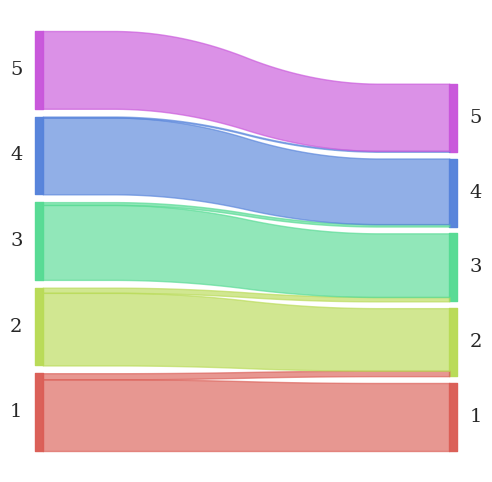

1960
1650
m-to-n


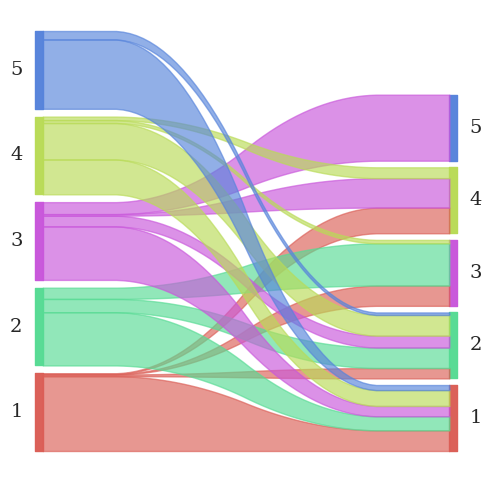

4932
3092
crowding


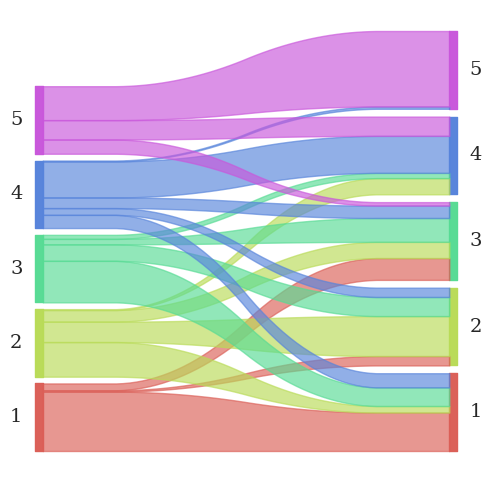

5978
5237
cannibalistic


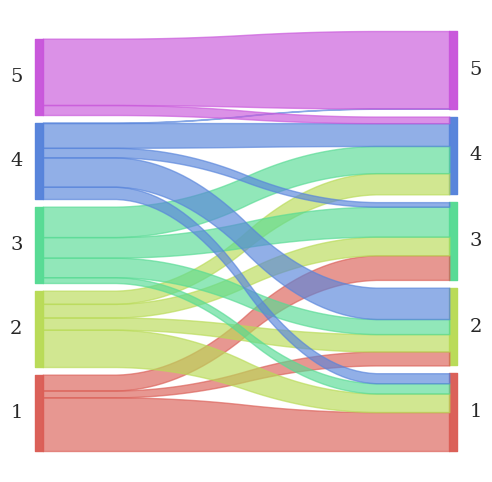

7127
4127
crowding innovation


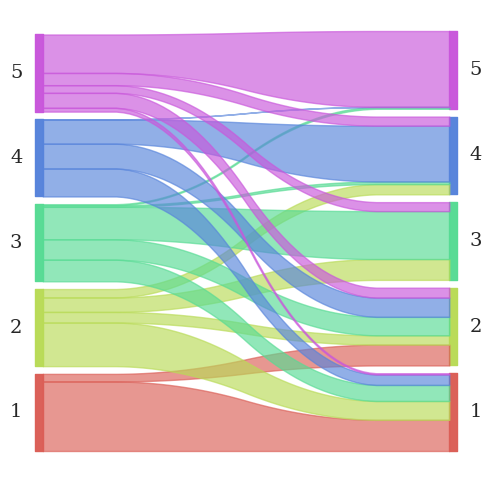

5325
6029
cannibalistic innovation


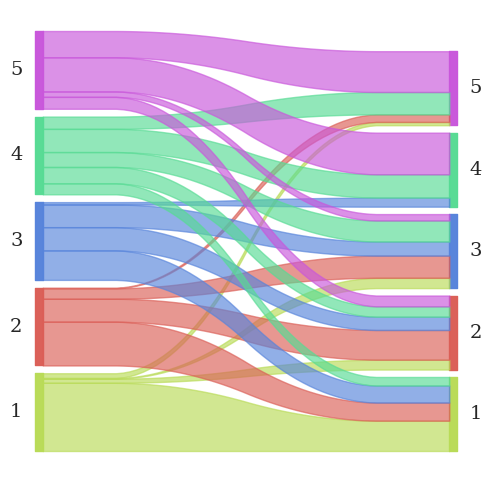

In [324]:
def get_quintile(income, percent_population):
    ind = np.argsort(income)
    ind_back = np.argsort(ind)
    percent_population = np.cumsum(percent_population[ind])
    print(np.sum(percent_population > 0.8))
    quintile = np.where(percent_population <= 0.2, 1, 0)
    quintile = np.where(np.all([percent_population > 0.2, percent_population <= 0.4], 0), 2, quintile)
    quintile = np.where(np.all([percent_population > 0.4, percent_population <= 0.6], 0), 3, quintile)
    quintile = np.where(np.all([percent_population > 0.6, percent_population <= 0.8], 0), 4, quintile)
    quintile = np.where(percent_population > 0.8, 5, quintile)
    quintile = quintile[ind_back]
    return quintile


def plot_mobility(labor_hist, prod_hist):
    agg_labor_hist, agg_prod_hist = [np.sum(l) for l in labor_hist], [np.sum(p) for p in prod_hist]
    T = len(labor_hist)
    percent_population_parent = labor_hist[int(T/2)] / agg_labor_hist[int(T/2)]
    income_parent = prod_hist[int(T/2)] / agg_labor_hist[int(T/2)]
    percent_population_child = labor_hist[-1] / agg_labor_hist[-1]
    income_child = prod_hist[-1] / agg_labor_hist[-1]
    
    percent_population_parent = np.repeat(percent_population_parent, 1000) / 1000
    income_parent = np.repeat(income_parent, 1000) / 1000
    percent_population_child = np.repeat(percent_population_child, 1000) / 1000
    income_child = np.repeat(income_child, 1000) / 1000
    
    quintile_parent = get_quintile(income_parent, percent_population_parent)
    quintile_child = get_quintile(income_child, percent_population_child)
    sankey(quintile_parent, quintile_child, leftWeight=percent_population_parent * agg_labor_hist[int(T/2)], rightWeight=percent_population_child * agg_labor_hist[-1])


for i in range(len(econ_list)):
    plot_mobility(econ_list[i].labor_hist, econ_list[i].production_hist)
    print(econ_names[i])
    plt.show()

In [325]:
for i in range(len(econ_list)):
    print(np.min(econ_list[i].labor_hist))

0.9754392849852389
2.5029813578375453e-15
3.9026077765284495e-14
5.9770302844714245e-15
2.686356337433166e-12
3.206469801173491e-16
